In [26]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
import hvplot.pandas
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as st
import numpy as np
import datetime as dt
import seaborn as sns



# Import data
path = "No-Show Data.csv"

noshow_df = pd.read_csv(path)
noshow_df

,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Appointment_Date,Appointment_Outcome
0,75763,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,11/4/2023,8/15/2024,Show
1,84945,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,10/28/2023,7/11/2024,No-Show
2,88559,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,2/12/2023,10/26/2024,Show
3,72217,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,1/30/2023,1/31/2024,Show
4,44071,76.0,Male,Uninsured,True,False,Employed,Advanced Degree,False,12.568497,Urban,11/27/2023,3/3/2024,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,16333,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,11/24/2023,3/16/2024,No-Show
49996,11153,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,11/29/2023,12/5/2023,No-Show
49997,15966,92.0,Female,Uninsured,False,True,Student,NaN,True,34.457721,Suburban,11/20/2022,7/27/2024,NaN
49998,41988,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,5/2/2023,12/19/2023,No-Show


In [27]:
# Only want to inlcude rows that have values for the outcome we are trying to predict
noshow_df = noshow_df.dropna(subset=['Appointment_Outcome'])
noshow_df

,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Appointment_Date,Appointment_Outcome
0,75763,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,11/4/2023,8/15/2024,Show
1,84945,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,10/28/2023,7/11/2024,No-Show
2,88559,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,2/12/2023,10/26/2024,Show
3,72217,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,1/30/2023,1/31/2024,Show
6,34403,15.0,Female,Medicaid,NaN,False,Unemployed,High School,True,34.033755,Suburban,8/13/2023,7/23/2024,Show
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,91361,57.0,Female,Private,True,False,Student,High School,True,28.410940,Suburban,1/26/2024,3/1/2024,Show
49995,16333,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,11/24/2023,3/16/2024,No-Show
49996,11153,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,11/29/2023,12/5/2023,No-Show
49998,41988,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,5/2/2023,12/19/2023,No-Show


In [28]:
noshow_df.dtypes

Patient_ID                  int64
Age                       float64
Gender                     object
Insurance_Type             object
Chronic_Disease            object
Mental_Health_Status       object
Employment_Status          object
Education_Level            object
Transportation_Access      object
Distance_from_Facility    float64
Area_Type                  object
Booking_Date               object
Appointment_Date           object
Appointment_Outcome        object
dtype: object

In [29]:
# No duplicates
dup_patients = noshow_df[noshow_df.duplicated(['Patient_ID'])]
dup_patients

,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Appointment_Date,Appointment_Outcome


In [30]:
# Convert 'Booking_Date' and 'Appointment_Date' columns to datetime if not already
noshow_df[['Booking_Date', 'Appointment_Date']] = noshow_df[['Booking_Date', 'Appointment_Date']].apply(pd.to_datetime, errors='coerce')

# Convert 'Age' to Int
#noshow_df['Age'] = noshow_df['Age'].astype(int)

# Calculate the difference in days, handling NaT values
diff = (noshow_df['Appointment_Date'] - noshow_df['Booking_Date']).dt.days

# Insert 'Days Diff' column at position 13
noshow_df.insert(12, 'Days Diff', diff)
noshow_df

C:\Users\lucas\AppData\Local\Temp\ipykernel_26284\4197393453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshow_df[['Booking_Date', 'Appointment_Date']] = noshow_df[['Booking_Date', 'Appointment_Date']].apply(pd.to_datetime, errors='coerce')


,Patient_ID,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Booking_Date,Days Diff,Appointment_Date,Appointment_Outcome
0,75763,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,2023-11-04,285,2024-08-15,Show
1,84945,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,2023-10-28,257,2024-07-11,No-Show
2,88559,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,2023-02-12,622,2024-10-26,Show
3,72217,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,2023-01-30,366,2024-01-31,Show
6,34403,15.0,Female,Medicaid,NaN,False,Unemployed,High School,True,34.033755,Suburban,2023-08-13,345,2024-07-23,Show
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,91361,57.0,Female,Private,True,False,Student,High School,True,28.410940,Suburban,2024-01-26,35,2024-03-01,Show
49995,16333,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,2023-11-24,113,2024-03-16,No-Show
49996,11153,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,2023-11-29,6,2023-12-05,No-Show
49998,41988,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,2023-05-02,231,2023-12-19,No-Show


In [31]:
noshow_df = noshow_df.drop(columns=['Patient_ID','Booking_Date','Appointment_Date'])

In [32]:
noshow_df

,Age,Gender,Insurance_Type,Chronic_Disease,Mental_Health_Status,Employment_Status,Education_Level,Transportation_Access,Distance_from_Facility,Area_Type,Days Diff,Appointment_Outcome
0,93.0,Male,Medicare,False,True,Student,Advanced Degree,True,37.785038,Suburban,285,Show
1,52.0,Male,Uninsured,False,False,Employed,College,True,NaN,Rural,257,No-Show
2,8.0,Male,Medicare,True,NaN,NaN,Advanced Degree,True,27.277654,Rural,622,Show
3,5.0,Other,Medicare,False,True,Student,College,True,44.618708,NaN,366,Show
6,15.0,Female,Medicaid,NaN,False,Unemployed,High School,True,34.033755,Suburban,345,Show
...,...,...,...,...,...,...,...,...,...,...,...,...
49993,57.0,Female,Private,True,False,Student,High School,True,28.410940,Suburban,35,Show
49995,48.0,Female,NaN,True,True,Student,NaN,True,26.576418,Urban,113,No-Show
49996,5.0,Other,Medicaid,True,True,Student,NaN,False,20.674054,Suburban,6,No-Show
49998,53.0,Male,Medicaid,False,False,Employed,College,False,21.190068,Suburban,231,No-Show


In [33]:
noshow_df.nunique()

Age                         101
Gender                        3
Insurance_Type                4
Chronic_Disease               2
Mental_Health_Status          2
Employment_Status             4
Education_Level               3
Transportation_Access         2
Distance_from_Facility    40494
Area_Type                     3
Days Diff                   724
Appointment_Outcome           2
dtype: int64

In [34]:
noshow_df.dtypes

Age                       float64
Gender                     object
Insurance_Type             object
Chronic_Disease            object
Mental_Health_Status       object
Employment_Status          object
Education_Level            object
Transportation_Access      object
Distance_from_Facility    float64
Area_Type                  object
Days Diff                   int64
Appointment_Outcome        object
dtype: object

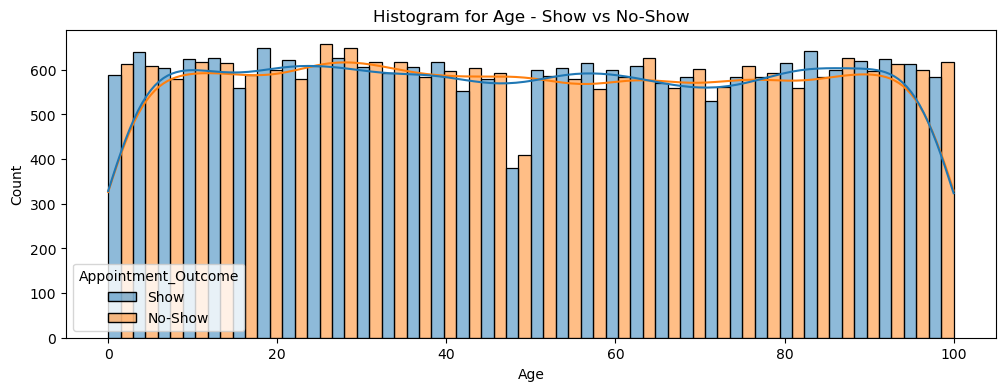

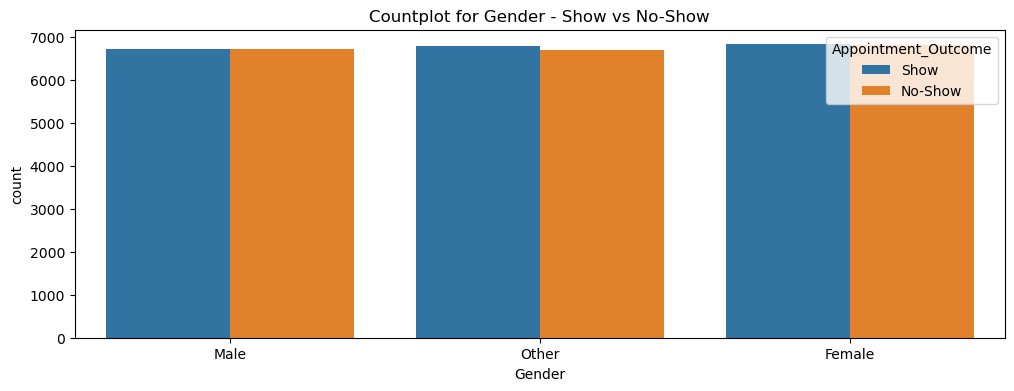

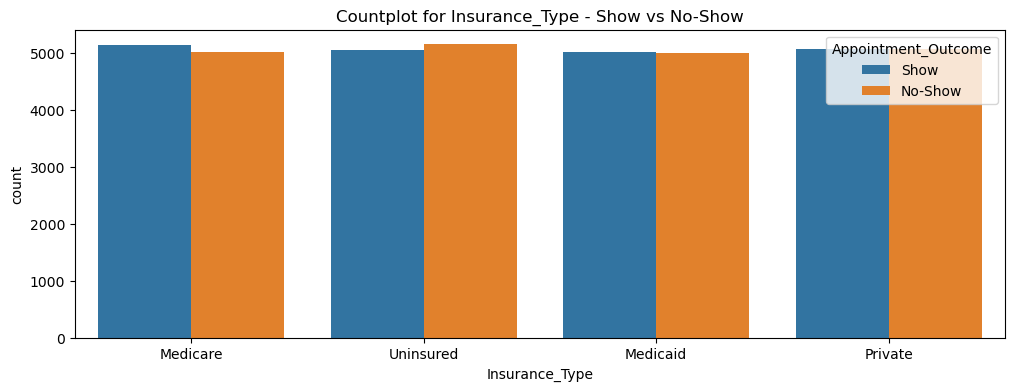

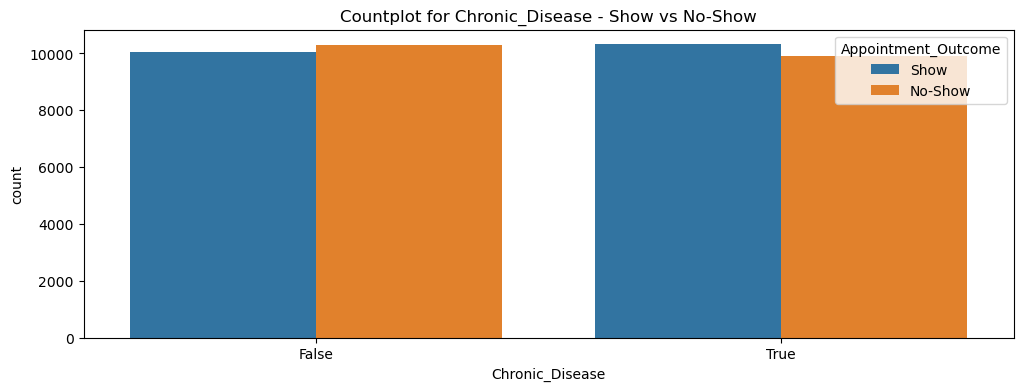

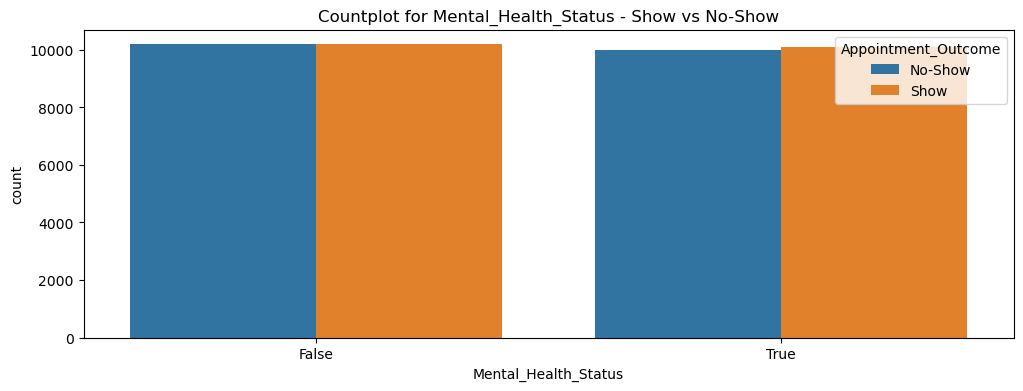

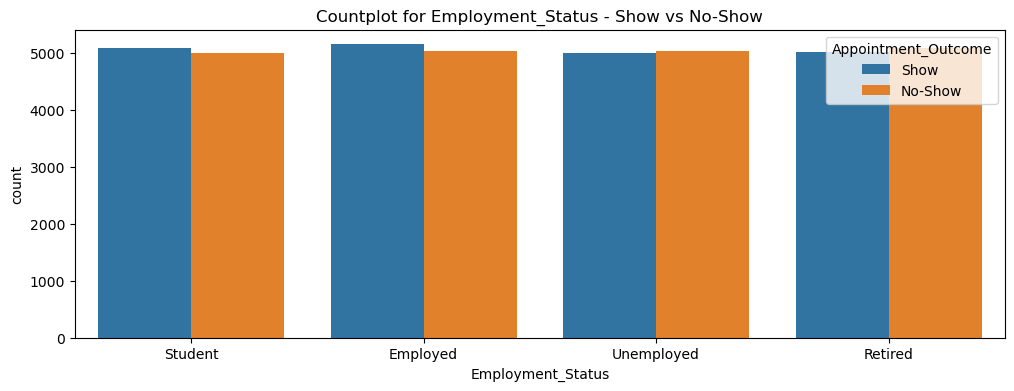

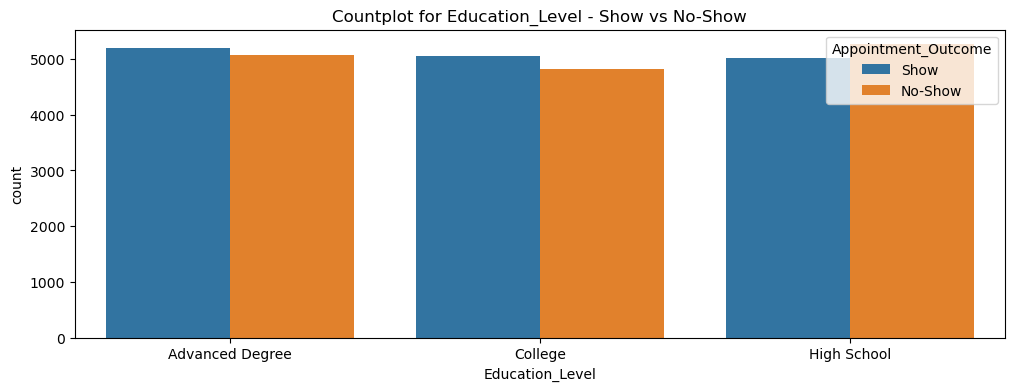

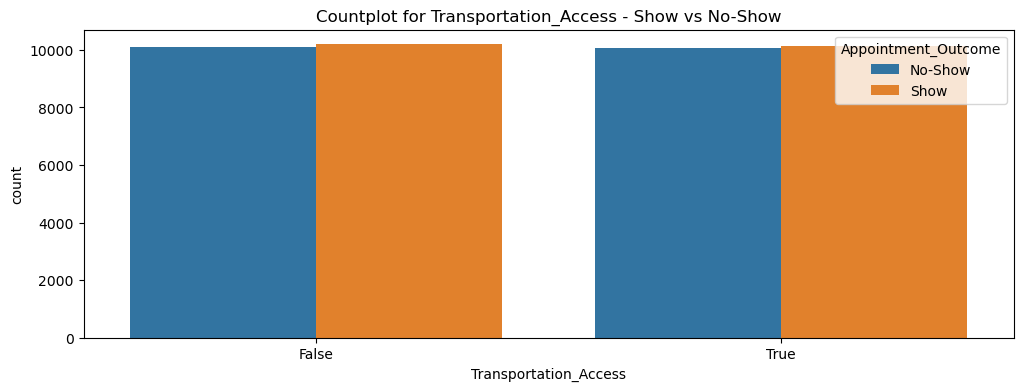

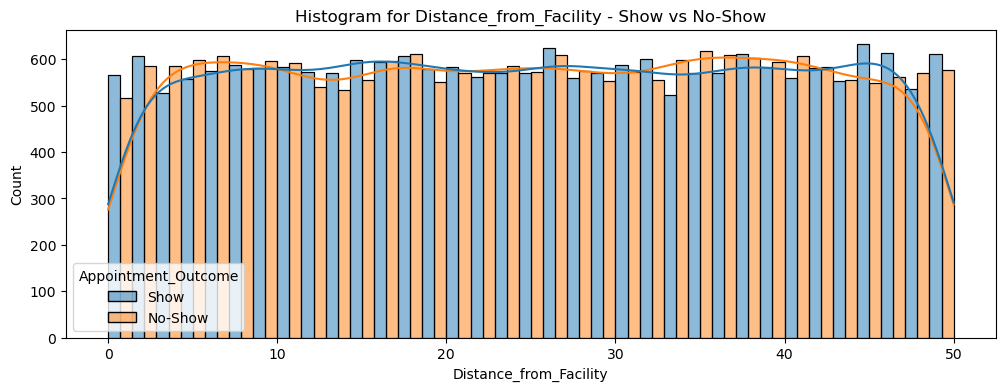

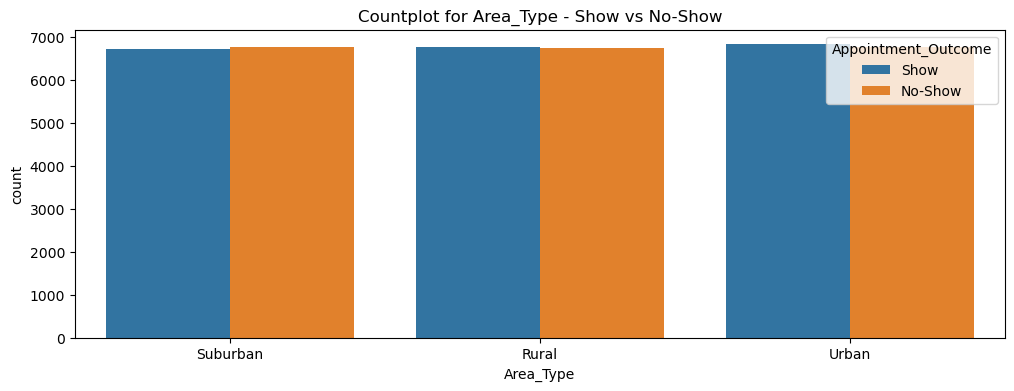

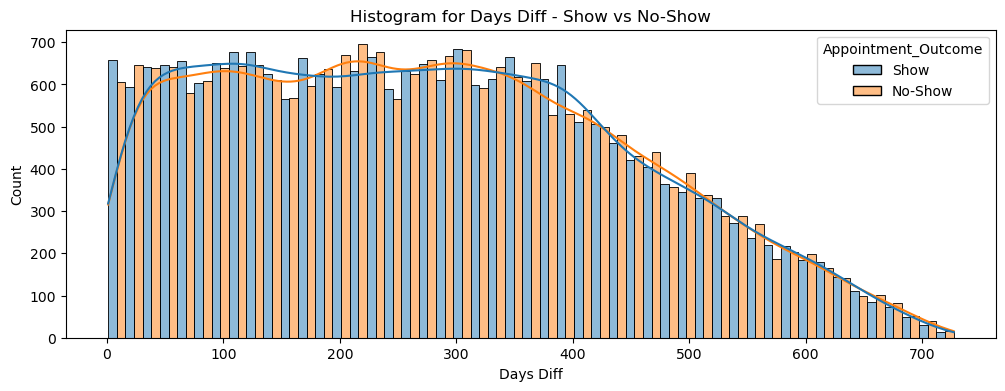

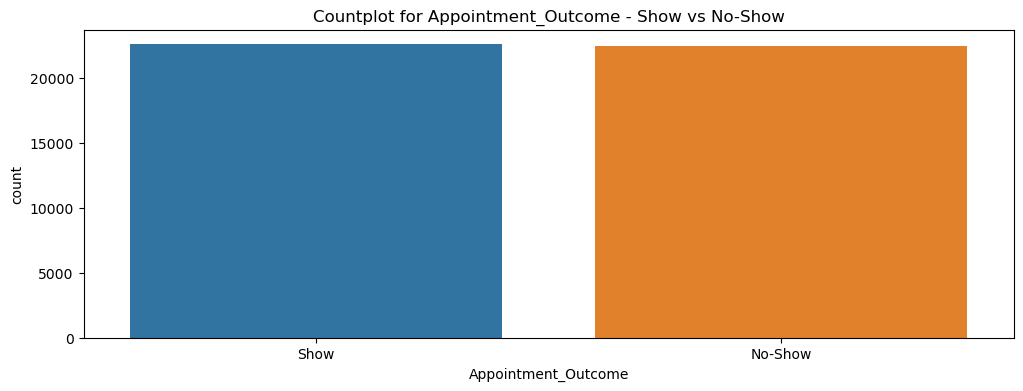

In [54]:
# Really evenly distributed data. Exception: About a 30% drop for patients around age 50. 
for column in noshow_df.columns:
    # Check if the column is numeric (int or float)
    if pd.api.types.is_numeric_dtype(noshow_df[column]):
        plt.figure(figsize=(12, 4))
        sns.histplot(data=noshow_df, x=column, hue="Appointment_Outcome", multiple="dodge", kde=True)
        plt.title(f'Histogram for {column} - Show vs No-Show')
        plt.show()
    else:
        # Handle categorical variables with countplot
        plt.figure(figsize=(12, 4))
        sns.countplot(data=noshow_df, x=column, hue="Appointment_Outcome")
        plt.title(f'Countplot for {column} - Show vs No-Show')
        plt.show()

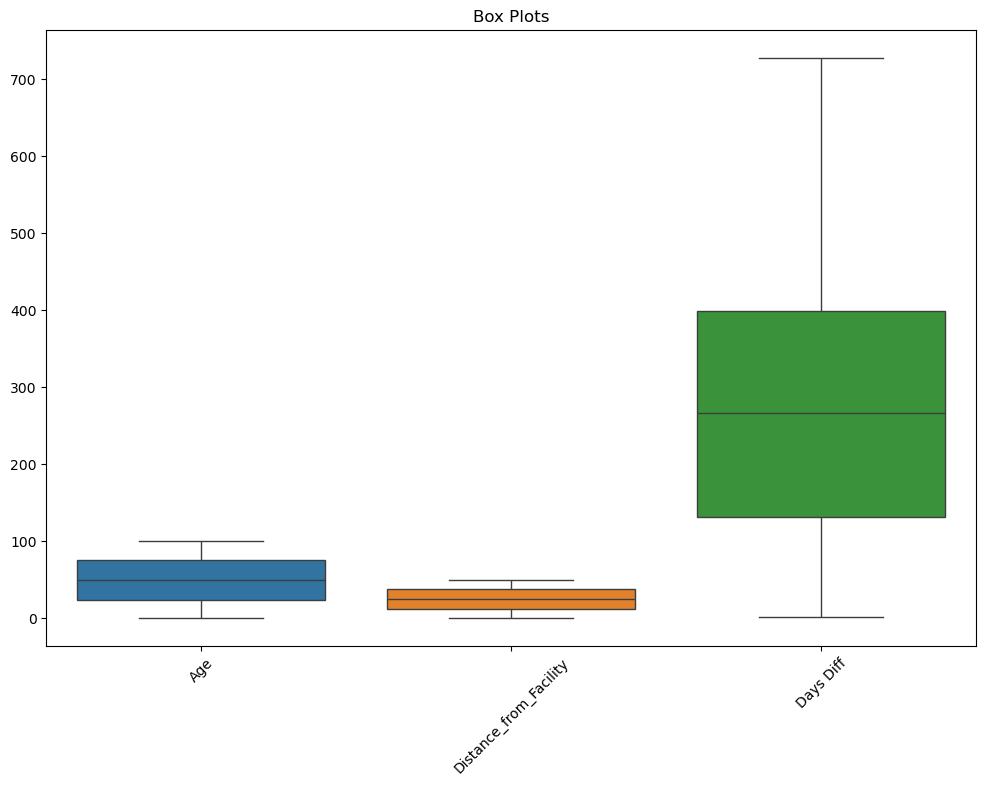

In [36]:
selected_columns = ['Age', 'Insurance_Type', 'Employment_Status', 'Distance_from_Facility', 'Days Diff']

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=noshow_df[selected_columns])
plt.title('Box Plots')
plt.xticks(rotation=45)
plt.show()

In [50]:
noshow_df.to_csv('clean_df.csv', index=False)